# Pair Matching (AKA Verification)

> A binary classsification task of deciding whether a pair of inputs "matches" (belongs to the same class) or not

In [ ]:
#| default_exp pair_matching

In [ ]:
#| hide
from nbdev.showdoc import *
from similarity_learning.utils import *

In [ ]:
#| hide
fix_notebook_widgets()

In [ ]:
#| export
import torch
from torch import nn
import numpy as np
from tqdm.autonotebook import tqdm

from fastai.vision.all import *

from similarity_learning.siamese import *
from similarity_learning.utils import *


class ThresholdSiamese(nn.Module):
    """Combines a deep similarity metric with a threshold to produce a binary classifier."""
    @delegates(DistanceSiamese)
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.distance = DistanceSiamese(*args, **kwargs)
        self.threshold = Threshold()

    def forward(self, x):
        return self.threshold(self.distance(x))

    @delegates(DistanceSiamese.plot_distance_histogram)
    def plot_distance_histogram(self, *args, **kwargs):
        self.distance.plot_distance_histogram(*args, **kwargs)
        plt.axvline(self.threshold.t.item(), linestyle='--', color='grey', label='Threshold')

In [ ]:
from fastai_datasets.all import *

In [ ]:
pairs = Pairs(Imagenette(160), .1)
dls = pairs.dls(after_item=Resize(128),
                after_batch=Normalize.from_stats(*imagenet_stats))

Class map: scanning targets: 0it [00:00, ?it/s]

Generating positive pairs:   0%|          | 0/473 [00:00<?, ?it/s]

Generating negative pairs:   0%|          | 0/473 [00:00<?, ?it/s]

Class map: scanning targets: 0it [00:00, ?it/s]

Generating positive pairs:   0%|          | 0/196 [00:00<?, ?it/s]

Generating negative pairs:   0%|          | 0/196 [00:00<?, ?it/s]

In [ ]:
classifier = resnet34(weights=ResNet34_Weights.DEFAULT)
siamese = ThresholdSiamese(create_body(model=classifier, cut=-1)).to(dls.device)

As explained in `Threshold.fit`, we can fit the threshold directly:

In [ ]:
#| export
@patch
def fit_threshold(self: ThresholdSiamese, train_dl: DataLoader):
    """Picks a threshold that maximizes the accuracy on a dataloader"""
    self.eval()
    with torch.no_grad():
        distances, targets = zip(*((self.distance(x), y) for x, y in tqdm(train_dl, desc='Picking threshold')))
        distances, targets = torch.cat(distances).as_subclass(Tensor), torch.cat(targets).as_subclass(Tensor)

        return self.threshold.fit(distances, targets) 

In [ ]:
siamese.fit_threshold(dls.train)

learn = Learner(dls, siamese, metrics=accuracy)
learn.validate()

(#2) [0.532600998878479,0.8877550959587097]

In [ ]:
learn.fit(5, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.511534,0.381983,0.946429,00:09
1,0.409406,0.324907,0.954082,00:09
2,0.343663,0.297324,0.956633,00:09
3,0.297677,0.274996,0.961735,00:09
4,0.264862,0.263369,0.959184,00:09


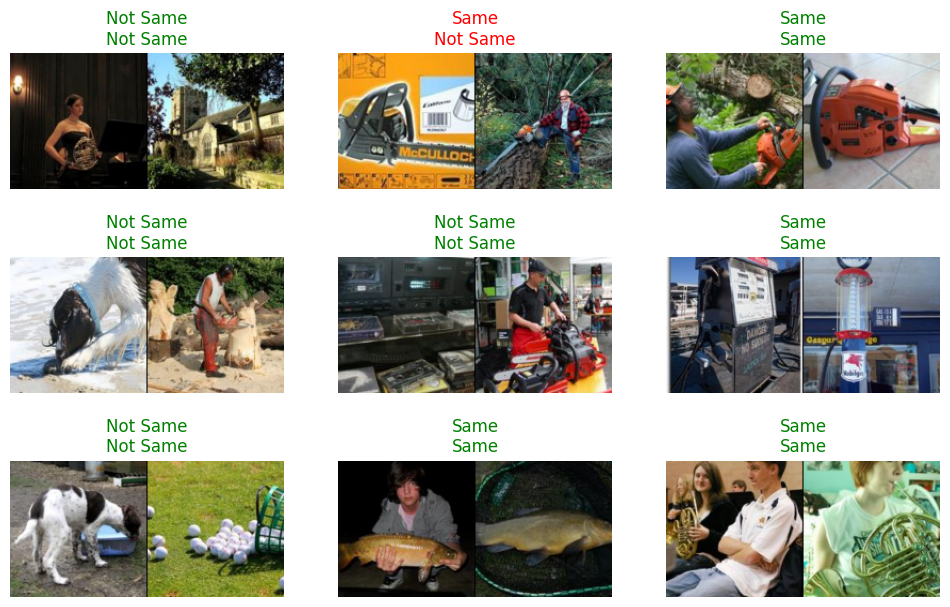

In [ ]:
learn.show_results()

If we plot the distance histogram, we can also see the threshold:

Computing distances:   0%|          | 0/14 [00:00<?, ?it/s]

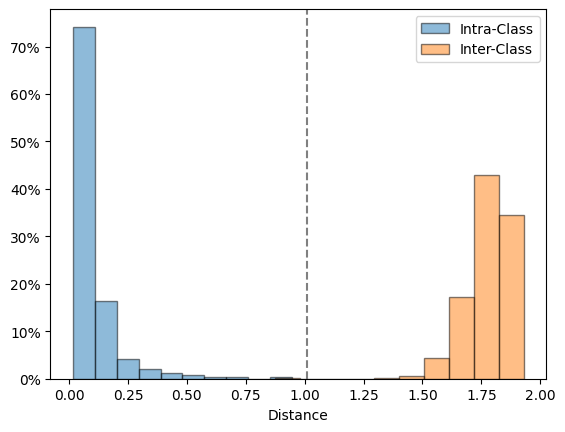

In [ ]:
siamese.plot_distance_histogram(dls.train)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()